# Laboratoire 1 : Extraction de primitives
#### Département du génie logiciel et des technologies de l’information

| Étudiants             | LEMARCHANT HUGO - AP85480 | TAN ELODIE - TANE25619607   | 
|-----------------------|---------------------------------------------------------|
| Cours                 | GTI770 - Systèmes intelligents et apprentissage machine |
| Session               | AUTOMNE 2018                                            |
| Groupe                | c                                                       |
| Numéro du laboratoire | 1                                                       |
| Professeur            | Prof. Hervé Lombaert                                    |
| Chargé de laboratoire | Pierre-Luc Delisle                                      |
| Date                  | 2018/09/27                                              |

In [33]:
# -*- coding:utf-8 -*-
import numpy as np
import cv2
import core
import matplotlib.pyplot as plt
import sys
import os, random
import math
from sklearn import tree
import scipy.ndimage as nd
import csv

In [36]:
# Hugo
pathHugo = "E:\\DocsPerso\\DocsBoulot\\ETS-MTL\\GTI770-02-SystIntel&MachineLearning\\data\\data\\images\\"
# JS
path= '/Users/jslecointre/Documents/DataScience/courses/MACHINE_LEARNING/TP/data/images/'
pathElodie = '/Users/raen/Documents/UTC/ETS/GTI770/GTI770-Data/images/'
exts = ".jpg"
nb_img = "107231"

path = path + nb_img + exts
imgFile = cv2.imread(pathHugo + nb_img + exts)
GP=core.GalaxyProcessor(path)

### Feature #1 ratio_aspect

In [105]:
def get_ratio_aspect(img, threshold):
    """
    Calculate the ratio of the bounding revtangle containing the largest contoured element. Most of the time the galaxy.
    
    args : image read by the cv2.imread function.
    
    Returns the ratio and the values of width and lenght
    """
    if not isinstance(img, np.ndarray):
        return -1, (None, None)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret,thresh = cv2.threshold(img,threshold,255,0)
    im2,contours,hierarchy = cv2.findContours(thresh, 2, 2)
    cnt = max(contours, key = lambda cnt : len(cnt))
    rect = cv2.minAreaRect(cnt)
    ratio = rect[1][0]/(rect[1][1]+0.0000000001)
    #print("ratio = {}".format(ratio))
    return ratio, (rect[1][0], rect[1][1])

ratio, values = get_ratio_aspect(imgFile, 127)

+ bleus représentent smooth
+ oranges représentent spiral


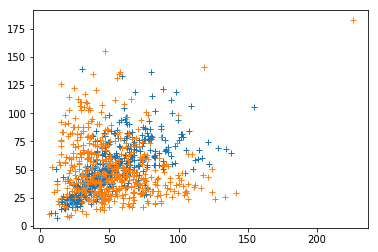

In [119]:
def test_ratio_feature(threshold):
    with open('galaxy/galaxy.csv', 'r') as f:  
        reader = csv.reader(f)  
        count = 0
        X = np.array([[None, None]])
        Y = [None]
        for row in reader:
            if (count >= 1 and count <= 500) or (count >= 11164 and count <= 11663):
                image = cv2.imread(pathHugo + "/{}.jpg".format(row[0]))
                ratio, values = get_ratio_aspect(image, threshold)
                if not (ratio == -1):
                    X = np.append(X, [[values[0], values[1]]], axis=0)
                    Y.append(row[1])
            count += 1
    print("+ bleus représentent {}".format(Y[1]))
    print("+ oranges représentent {}".format(Y[-1]))
    plt.plot(X[1:501,0], X[1:501,1], '+')
    plt.plot(X[501:1001,0], X[501:1001,1], '+')
    
test_ratio_feature(95)

### Feature #2 CCV

In [185]:
def QuantizeColor(img, N=64):
    
    div = 256//N
    rgb = cv2.split(img)
    quantized_list = []
    
    # quantize N colors for each channel
    for ch in rgb:
        vf = np.vectorize(lambda x, div: int(x//div)*div)
        quantized = vf(ch, div)
        quantized_list.append(quantized.astype(np.uint8))
    
    # Merge the channels after quantization
    d_img = cv2.merge(quantized_list)
    
    return d_img

def plt_display(title,img):
    
    print('image: {0} shape: {1}'.format(title,img.shape))
    plt.imshow(img)
    plt.title(title)
    plt.show() 
    
def get_ccv(src,Threshold,N,prt=False):
    
    img = src.copy()
    if prt:
        plt_display('Original image',img)
    
    (row, col, channels) = img.shape
    #print('shape : {0},{1},{2}'.format(row, col, channels))

    # blur
    img = cv2.GaussianBlur(img, (3, 3), 0)
    if prt:
        plt_display('After blur',img)

    # quantize color

    img = QuantizeColor(img, N)
    if prt:
        plt_display('After Quantization',img)
    
    bgr = cv2.split(img)
    #print('b={0},g={1},r={2}'.format(len(bgr[0]),len(bgr[1]),len(bgr[2])))

    # bgr = cv2.split(cv2.cvtColor(img, cv2.COLOR_BGR2HSV))    
    alpha = np.zeros(N)
    beta = np.zeros(N)

    # labeling
    for (i, ch) in enumerate(bgr):
        (ret, th) = cv2.threshold(ch, 127, 255, 0)
        
        if prt:
            plt_display('after threshold',img)   
    
        (ret, labeled, stat, centroids) = cv2.connectedComponentsWithStats(th, None,cv2.CC_STAT_AREA, None, connectivity=8)

        # generate ccv
        print('stat : {0}'.format(stat.shape))
        areas = [[v[4], label_idx] for (label_idx, v) in enumerate(stat)]
        coord = [[v[0], v[1]] for (label_idx, v) in enumerate(stat)]

        # Counting coherent and incoherent pixels
        for (a, c) in zip(areas, coord):
            area_size = a[0]
            (x, y) = (c[0], c[1])
            
            if x < ch.shape[1] and y < ch.shape[0]:
                bin_idx = int(ch[y, x] // (256 // N))
                if area_size >= Threshold:
                    # COHERENT PIXELS (belong to area > Threshold pixels )
                    alpha[bin_idx]+= area_size
                else:
                    # INCOHERENT PIXELS (belong to area <= Threshold pixels )
                    beta[bin_idx]+= area_size
    
    return (alpha, beta)

def ccv_plot(img,alpha,beta,N):

    X = [x for x in range(N * 2)]
    Y = alpha.tolist() + beta.tolist()

    with open('ccv.csv', 'w') as f:
        f.write(str(Y))
    
    im = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.subplot(2, 1, 1)
    plt.imshow(im)
    plt.subplot(2, 1, 2)
    plt.bar(X, Y, align='center')

    plt.yscale('log')
   
    plt.show()

stat : (2, 5)
stat : (2, 5)
stat : (1, 5)


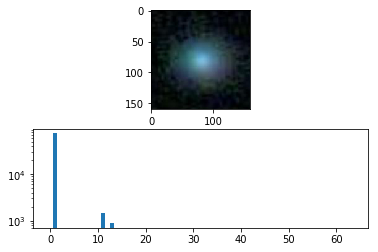

In [188]:
path='/Users/jslecointre/Documents/DataScience/courses/MACHINE_LEARNING/TP/data/images/'
filename=random.choice(os.listdir(path))
img = cv2.imread('{0}{1}'.format(path,filename))
im_color=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
im_cropped=GP.crop_image(im_color, 212-80, 212+80)
#plt_display('image cropped 160x160',im_cropped)   
#im_grey=cv2.cvtColor(img.astype("uint8"), cv2.COLOR_BGR2GRAY)

N=32
coherence_threshold_percent=0.01
alpha, beta = get_ccv(im_cropped, Threshold=im_cropped.shape[0]**2*coherence_threshold_percent,N=N,prt=False)
#print('{0},{1}'.format(alpha, beta))
CCV = alpha.tolist()+beta.tolist()
assert(sum(CCV) == im_cropped.size)
assert(N == len(alpha) and N == len(beta))

ccv_plot(im_cropped, alpha, beta, N)

### Feature #3 Circularity

In [43]:
def calculateCircularity(img):
    """calculateCircularity 
    Fonction calculant la circularité d'une image de galaxie grâce à la fonction C = 4pi * A/P2.


    Args:
        img (int): L'image pour laquelle nous voulons calculer la circularité.

    Returns:
        circularity: La valeur de retour. Elle est définie entre 0 et 1. 
                    Plus la valeur est proche de 1, plus la galaxie est circulaire.

    """
    
    log = nd.gaussian_laplace(img, sigma=20)
    img = img - log
    
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY); 
    ret, thresh = cv2.threshold(gray_img, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    kernel = np.ones((3,3),np.uint8)
    dilation = cv2.dilate(thresh,kernel,iterations = 1)


    # Get moment to calculate area
    img2, contours, hierarchy = cv2.findContours(thresh, 1, 2)
    contour = contours[0]
    M = cv2.moments(contour)
    area = M['m00']
    
    #Get perimeter : 
    perimeter = cv2.arcLength(contour,True)
    if perimeter == 0:
        perimeter = 0.1
    
    # Circularity
    circularity = 4 * math.pi * area / (perimeter**2)
    
    return circularity



In [47]:
image = plt.imread(path)
plt.imshow(image)
plt.show()

calculateCircularity(image)

FileNotFoundError: [Errno 2] No such file or directory: '/Users/jslecointre/Documents/DataScience/courses/MACHINE_LEARNING/TP/data/images/107231.jpg'

## Fonction calcul des primitives

In [144]:
def calculateAttributes(path):
    with open('galaxy/galaxy.csv', 'r') as f:  
        
        reader = csv.reader(f)  
        count = 0
        X = []
        Y = []
        attributes = []
        for row in reader:
            if (count >= 1 and count <= 50) or (count >= 11164 and count <= 11213):
                image = cv2.imread(path + "/{}.jpg".format(row[0]))
                X.append([row[0], image]) 
                Y.append([row[0], row[1]])
            count += 1
    
    for image in X:
        ratio = get_ratio_aspect(image[1])
        circularity = calculateCircularity(image[1])
        attributes.append([image[0], ratio, circularity])
    attributes = np.asarray(attributes)
    return attributes

attributes = calculateAttributes(pathElodie)


/Users/raen/anaconda3/envs/gti770_env/lib/python3.5/site-packages/ipykernel/__main__.py:2: DeprecationWarning: 'U' mode is deprecated
  from ipykernel import kernelapp as app


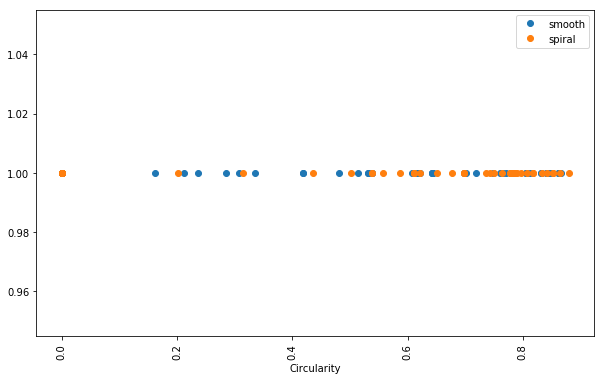

In [135]:
circularity = [float(line[2]) for line in attributes]

plt.figure(figsize=(10,6))
plt.plot(circularity[0:50], 50 * [1], "o", label = 'smooth')
plt.plot(circularity[51:100], 49 * [1], "o", label = 'spiral')
plt.xlabel('Circularity')
plt.xticks(rotation=90)
plt.legend()
plt.show()

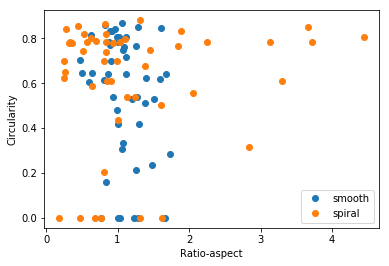

In [143]:
ratio = [float(line[1]) for line in attributes]

plt.plot(ratio[0:49], circularity[0:49], 'o', label='smooth')
plt.plot(ratio[50:99], circularity[50:99], 'o', label='spiral')
plt.xlabel('Ratio-aspect')
plt.ylabel('Circularity')
plt.legend()
plt.show()

In [ ]:
# utiliser les arbres de décision
X = [[0, 0], [1, 1]]
Y = [0, 1]
clf = tree.DecisionTreeClassifier()
clf = clf.fit(data, classes, max_depth = 3)

## Questions

### Question 1 : Introduction et revue de la littérature

Après lecture des différents papiers de recherche, nous nous sommes concentré sur Morphological classification of galaxies into spirals and non-spirals (D. Dhami). En effet, ses travaux répondent parfaitement à la problématique qui nous est posée, c'est à dire la différenciation entre les galaxies rondes et celles en forme de spirale. Plusieurs caractéristiques de galaxies sont étudiées dans sa recherche, et elle explicite aussi celles qui fonctionnent le mieux. 


### Question 2

Nous avons donc choisi d'étudier :

- La circularité
- CCV
- Ratio-aspect

Pour ce qui est de la circularité, nous avons effectué plusieurs recherches sur comment la calculer. La plupart des sites mentionnent la formule $ C = 4 * \pi * area / P^2 $.

### Question 3

### Question 4

### Question 5

### Conclusion

### Bibliographie